Implementation, testing and training of a Transformer machine learning model

In [1]:
import os
import torch
import pickle
import warnings
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_forecasting.data import GroupNormalizer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_forecasting.metrics import SMAPE, QuantileLoss
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


warnings.filterwarnings("ignore")
os.chdir("..")

Filtering the data and creating the needed features that will be fed into the model

In [2]:
data = pd.read_csv("data/All_music.csv")
data.sort_values(by=["timestamp"],inplace=True) # for my sanity
data["timestamp"] = pd.to_datetime(data["timestamp"]) # needed to create time_index

#group by month
# data["time_idx"] = data["timestamp"].dt.year * 12 + data["timestamp"].dt.month
# data["time_idx"] -= data["time_idx"].min()

data["month"] = data["timestamp"].dt.month.astype(str).astype("category")
data["log_views"] = np.log(data["views"] + 1e-8)


data["time_idx"] = data.index.astype(int)
#data["timestamp"] = data["timestamp"].astype(str).astype('category')
# (data.groupby("project")["time_idx"].diff() == 1).value_counts()


# # add time index
# data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
# data["time_idx"] -= data["time_idx"].min()
data.drop(["project","granularity","access","agent"],inplace=True,axis=1)
data["article"] = data["article"].astype(str).astype("category")

# Delete wrong data
data = data[data["article"] != "Paper_Doll"]
data = data[data["article"] != "Y.M.C.A"]
data = data[data["article"] != "Bei_Mir_Bist_Du_Schön"]


#new Features
data["dayofweek"] = data["timestamp"].dt.dayofweek.astype(str).astype("category")
data["log_views"] = np.log(data["views"] + 1e-8)
data["month"] = data["timestamp"].dt.month.astype(str).astype("category")
data["year"] = data["timestamp"].dt.year.astype(str).astype("category")
data["avg_by_song"] = data.groupby(["month","year","article"],observed=True)["views"].transform("mean")


data = data[data['article'].map(data['article'].value_counts()) == 2377]
data.drop("Unnamed: 0",inplace=True,axis=1)
data.sort_values(by=["article","timestamp"],inplace=True)
data["time_idx"] = [i for i in range(2377)] * len(data["article"].unique())
data

,article,timestamp,views,month,log_views,time_idx,dayofweek,year,avg_by_song
0,(Everything_I_Do)_I_Do_It_for_You,2015-07-01,639,7,6.459904,0,2,2015,682.548387
1,(Everything_I_Do)_I_Do_It_for_You,2015-07-02,647,7,6.472346,1,3,2015,682.548387
2,(Everything_I_Do)_I_Do_It_for_You,2015-07-03,549,7,6.308098,2,4,2015,682.548387
3,(Everything_I_Do)_I_Do_It_for_You,2015-07-04,638,7,6.458338,3,5,2015,682.548387
4,(Everything_I_Do)_I_Do_It_for_You,2015-07-05,774,7,6.651572,4,6,2015,682.548387
...,...,...,...,...,...,...,...,...,...
150686,You're_the_One_That_I_Want,2021-12-28,217,12,5.379897,2372,1,2021,191.064516
150687,You're_the_One_That_I_Want,2021-12-29,181,12,5.198497,2373,2,2021,191.064516
150688,You're_the_One_That_I_Want,2021-12-30,175,12,5.164786,2374,3,2021,191.064516
150689,You're_the_One_That_I_Want,2021-12-31,279,12,5.631212,2375,4,2021,191.064516


In [3]:
# checking for correct datatype
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121227 entries, 0 to 150690
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   article      121227 non-null  category      
 1   timestamp    121227 non-null  datetime64[ns]
 2   views        121227 non-null  int64         
 3   month        121227 non-null  category      
 4   log_views    121227 non-null  float64       
 5   time_idx     121227 non-null  int64         
 6   dayofweek    121227 non-null  category      
 7   year         121227 non-null  category      
 8   avg_by_song  121227 non-null  float64       
dtypes: category(4), datetime64[ns](1), float64(2), int64(2)
memory usage: 6.0 MB


Creating the test and training split and the transoformer model.

Noteable params:

    The data used to train this model are only the Musical data
    Training days: 365 days
    Days to predict: 14 days

In [3]:
max_encoder_length = 365   #
max_prediction_length = 14  # predict last 14 days
test_cutoff = data.time_idx.max() - max_prediction_length
training_cutoff = test_cutoff - max_prediction_length

HIDDEN_SIZE = 16
HIDDEN_CONTINOUS_SIZE = HIDDEN_SIZE // 2
#create test set.
data_test = data[lambda x:  test_cutoff < x.time_idx]

# create train+val part
data_seen = data[lambda x:  x.time_idx <= test_cutoff]


training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="views",
    group_ids=["article"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    target_normalizer=GroupNormalizer(groups=["article"]),
    time_varying_known_categoricals=["dayofweek", "month", "year"],
    time_varying_known_reals=["log_views"],
    static_categoricals=["article"],
    time_varying_unknown_reals=["avg_by_song", "log_views"],
    #allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True)


# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(
    training, data_seen, predict=True, stop_randomization=True)


# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0)


# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

870.6036376953125

Finding the optimal learning rate for the Transformer model

In [5]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=HIDDEN_SIZE,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=HIDDEN_CONTINOUS_SIZE,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 20.7k


Training the model

In [4]:
l_r = 1.1220184543019632e-05
path = "Transformer/tft_model_hidden16_oneYear_newIndex.pth"


early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    gradient_clip_val=0.1,
    #limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    limit_train_batches=1.0, #if set to 1.0 gather all training data, default.
    callbacks=[lr_logger, early_stop_callback],
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=l_r,
    hidden_size=HIDDEN_SIZE,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=HIDDEN_CONTINOUS_SIZE,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)


if os.path.exists(path):
    tft.load_state_dict(torch.load(path))
    tft.eval()
else:
    trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
    
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

#torch.save(tft.state_dict(),path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


Number of parameters in network: 20.7k


Optimizing the model

In [7]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-01-13 19:47:44,365] A new study created in memory with name: no-name-60ecc931-9f7d-4bc3-9cf3-7cbd307aed88
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2023-01-13 19:48:03,474] Trial 0 finished with value: 783.876220703125 and parameters: {'gradient_clip_val': 0.7269322375736874, 'hidden_size': 14, 'dropout': 0.23115292489494219, 'hidden_continuous_size': 14, 'attention_head_size': 1, 'learning_rate': 0.013535745128311972}. Best is trial 0 with value: 783.876220703125.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [5]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
path = "Transformer/hidden_16_oneYear_new/epoch=43.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(path)

In [6]:
def smape(target, forecast):
  if type(target) == pd.core.frame.DataFrame:
    target = target.values

  denominator = np.abs(target) + np.abs(forecast)
  flag = denominator == 0.

  smape = 2 * np.mean(
      (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
  )
  return smape

In [7]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean().item()

119.79976654052734

In [8]:
# calculate sMAPE on validation set.
target = actuals.numpy()    
forecast = predictions.numpy()
smape(target, forecast)

0.1160969606775029

Comparing the normal model with the hyper optimized version

In [9]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
best_raw_predictions, best_x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)

Built in plotter

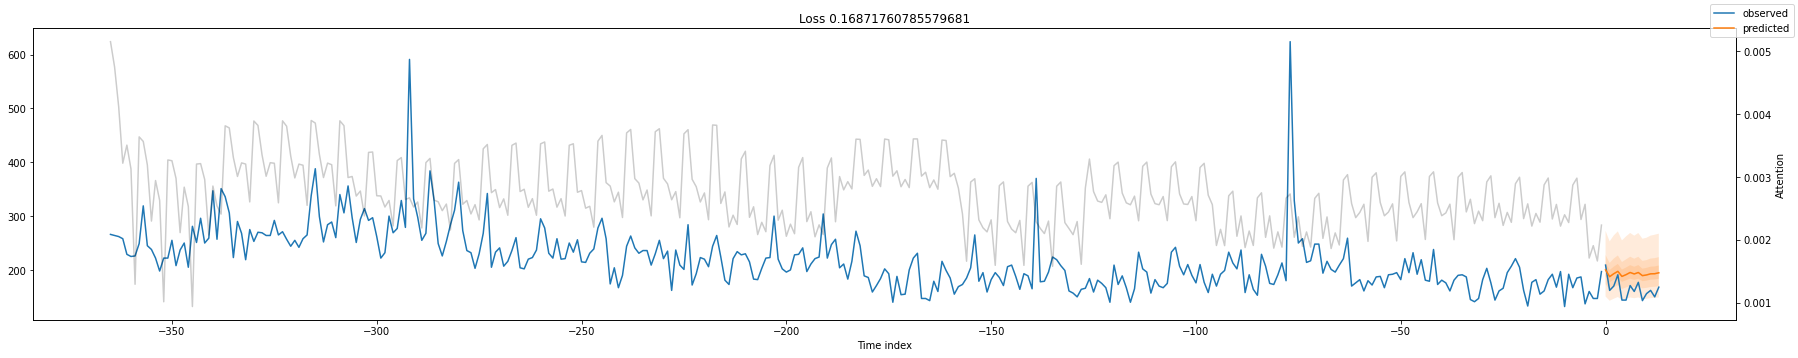

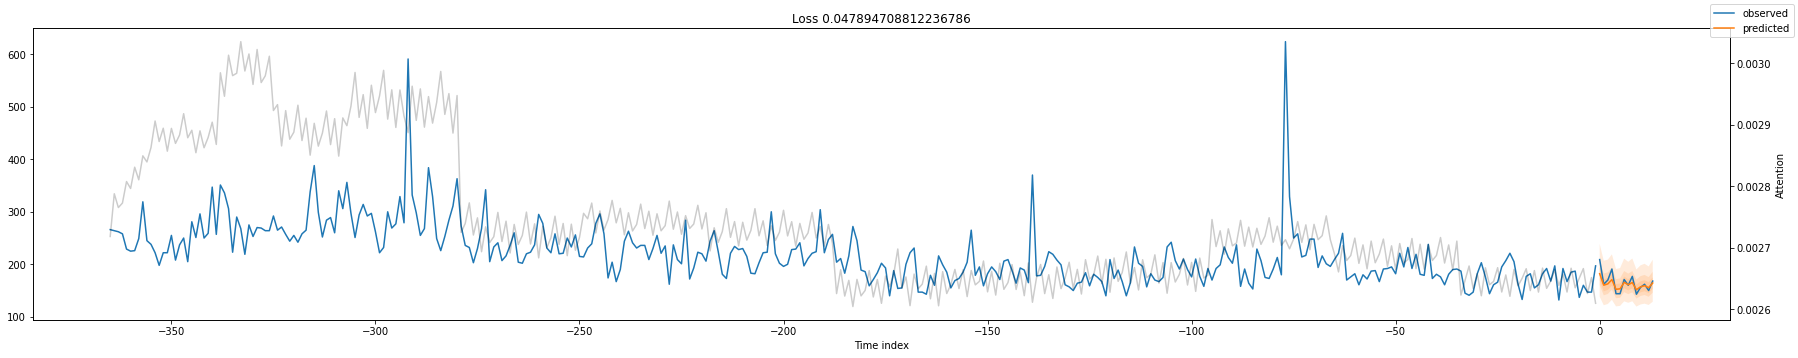

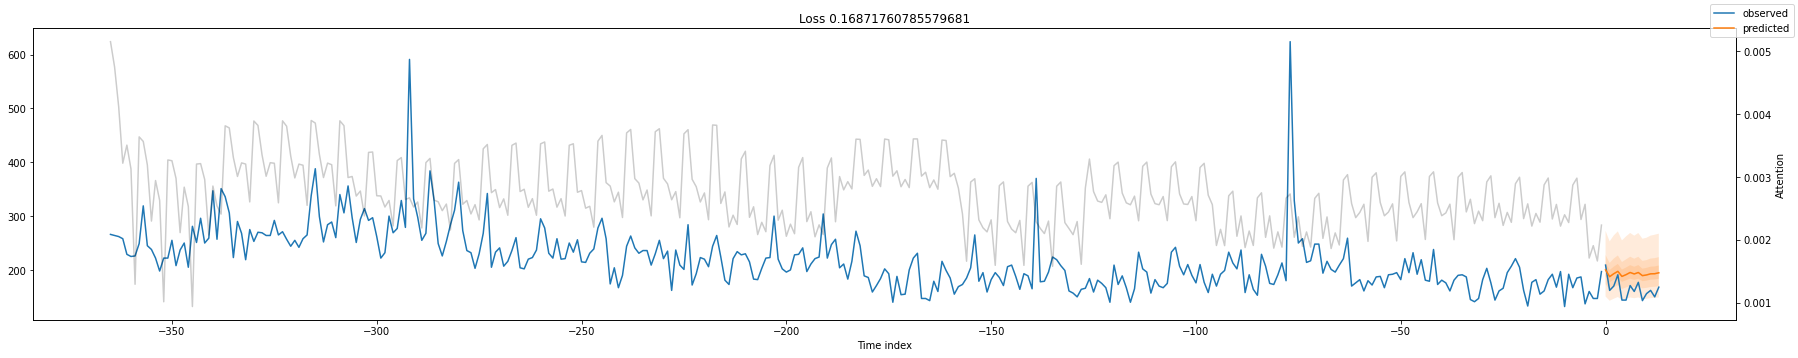

In [10]:
# calculate metric by which to display
from pylab import rcParams
rcParams['figure.figsize'] = 25, 5
best_predictions = best_tft.predict(val_dataloader)
predictions = tft.predict(val_dataloader)

mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
best_mean_losses = SMAPE(reduction="none")(best_predictions, actuals).mean(1)
# for idx in np.random.randint(0,50,size=5):  # plot 20 examples
#     best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
idx = 8
best_tft.plot_prediction(best_x, best_raw_predictions, idx=idx, add_loss_to_title=best_mean_losses)
tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=mean_losses)

{'attention': <Figure size 1800x360 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x252 with 1 Axes>,
 'decoder_variables': <Figure size 504x234 with 1 Axes>}

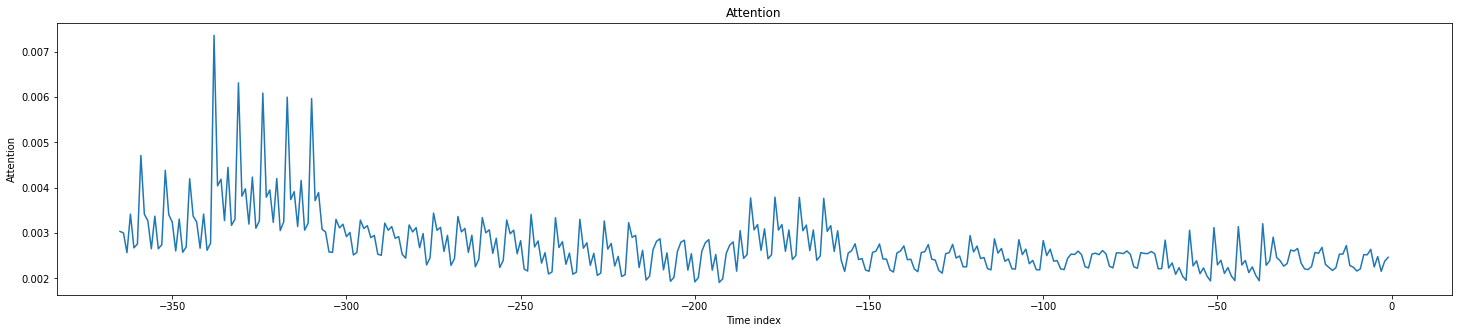

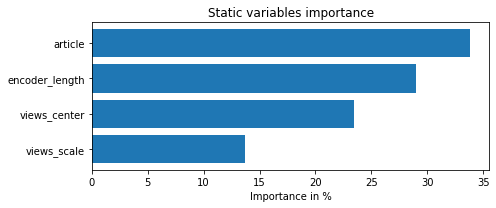

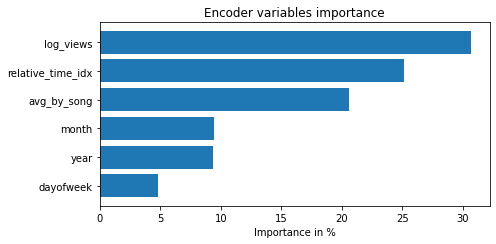

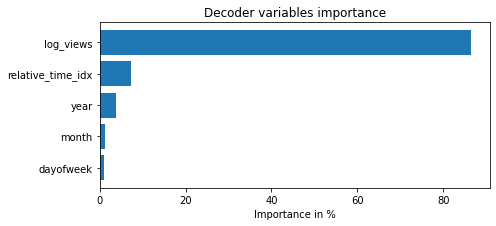

In [11]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

{'encoder_length': <Figure size 720x360 with 2 Axes>,
 'views_center': <Figure size 720x360 with 2 Axes>,
 'views_scale': <Figure size 720x360 with 2 Axes>,
 'log_views': <Figure size 720x360 with 2 Axes>,
 'relative_time_idx': <Figure size 720x360 with 2 Axes>,
 'avg_by_song': <Figure size 720x360 with 2 Axes>,
 'article': <Figure size 720x360 with 2 Axes>,
 'dayofweek': <Figure size 1800x360 with 2 Axes>,
 'month': <Figure size 720x360 with 2 Axes>,
 'year': <Figure size 1800x360 with 2 Axes>}

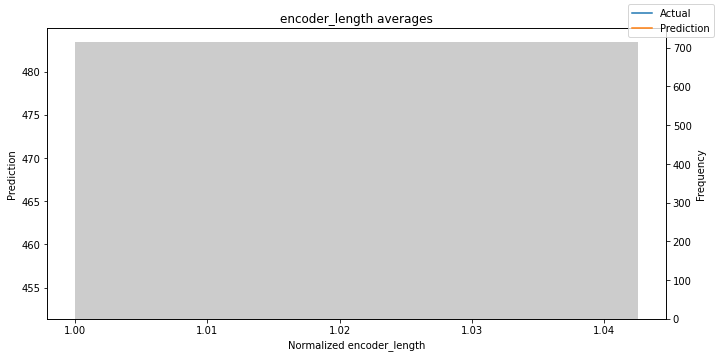

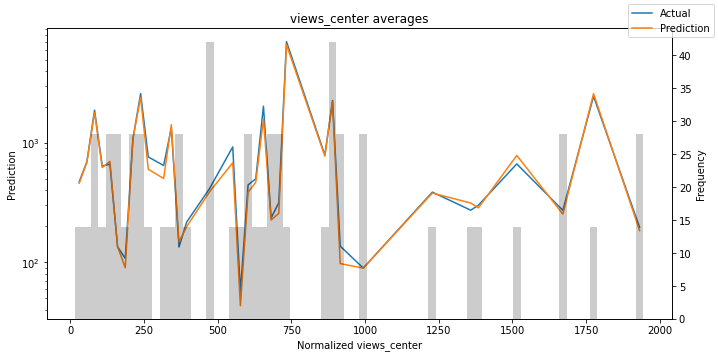

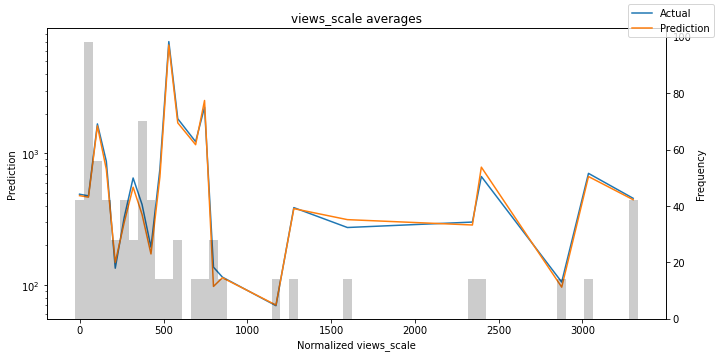

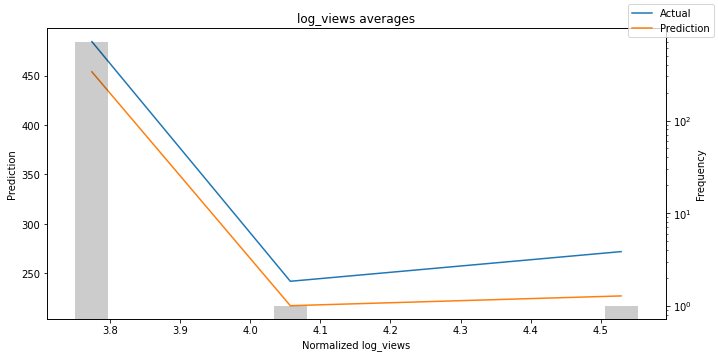

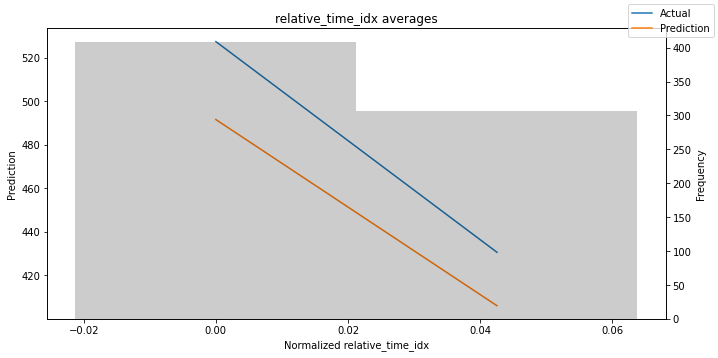

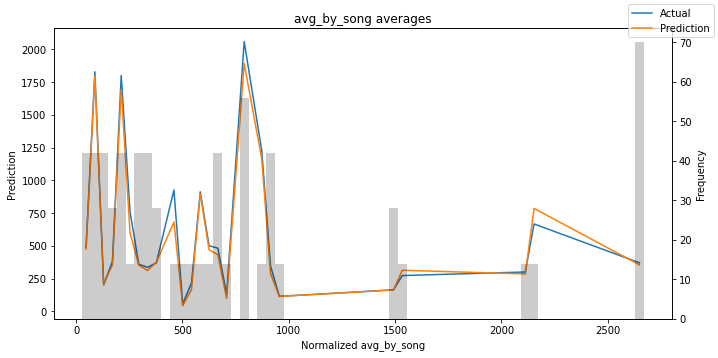

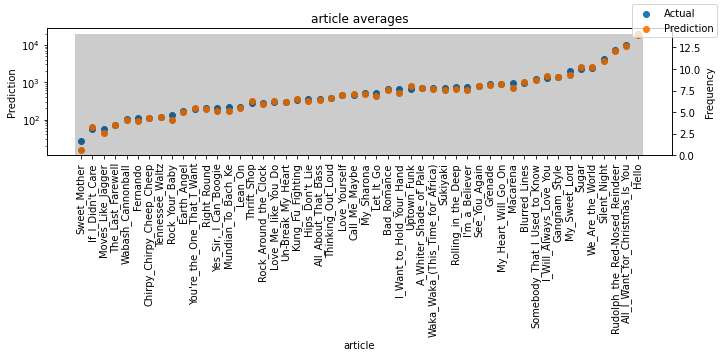

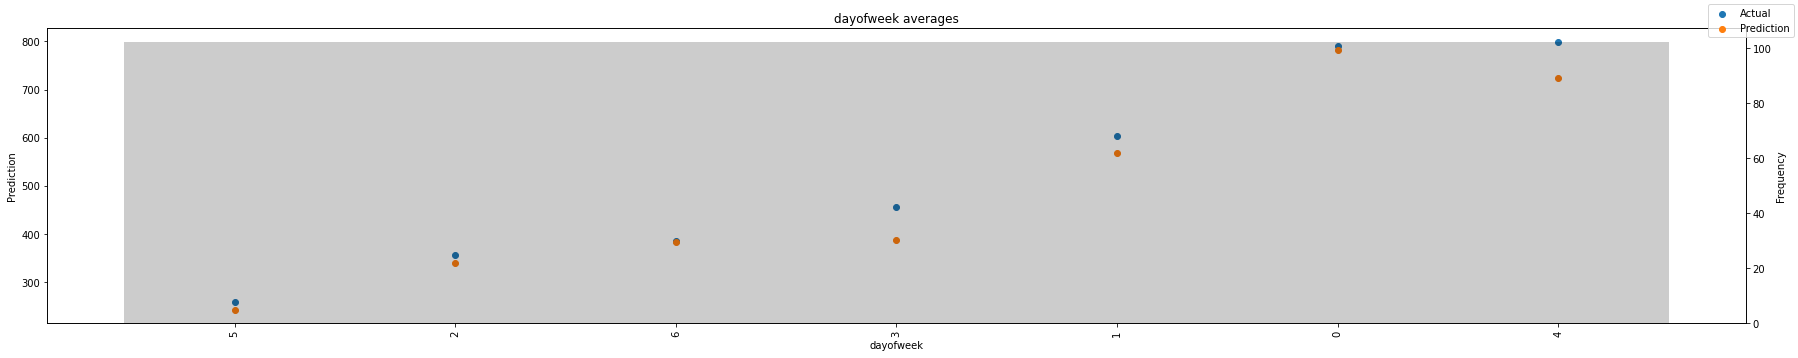

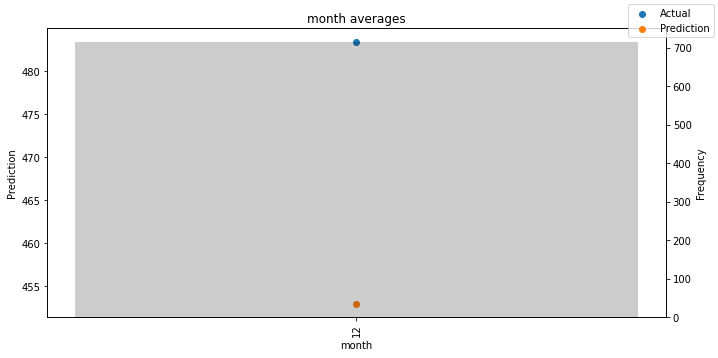

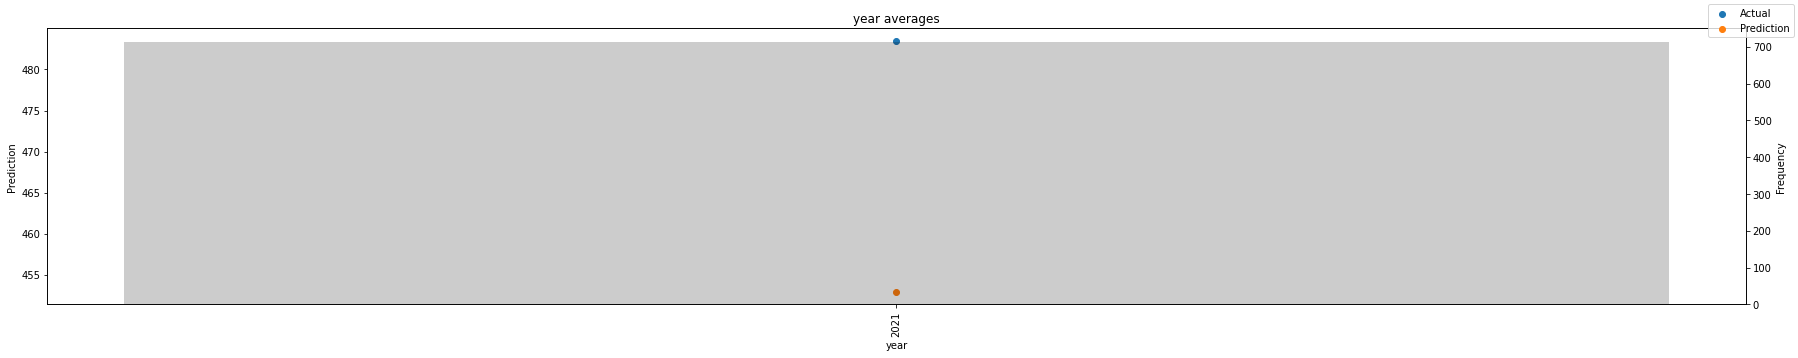

In [12]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

Plotting an All I Want For Christmas Is You prediction

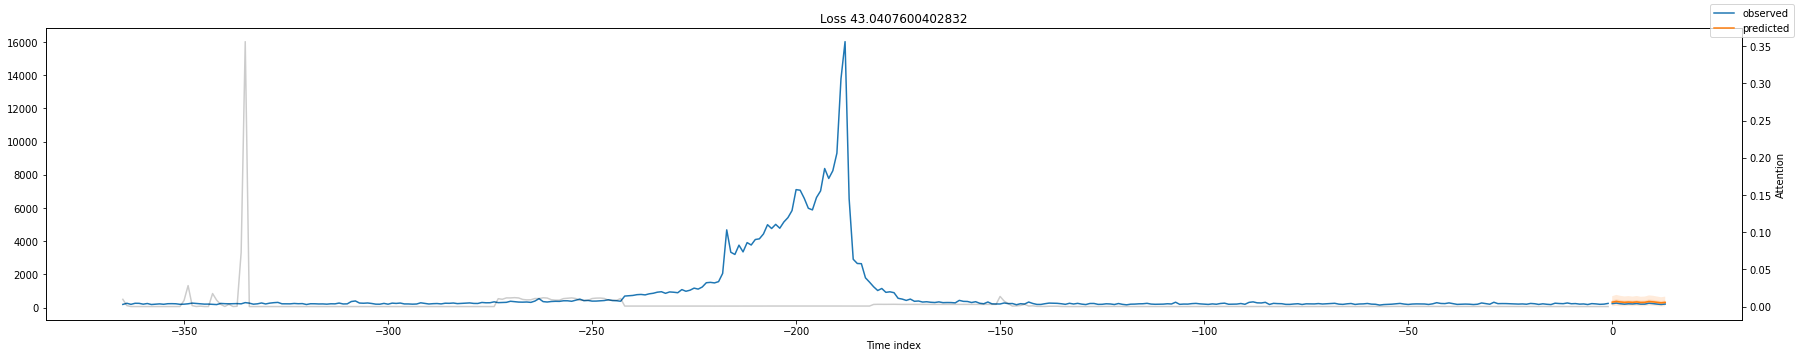

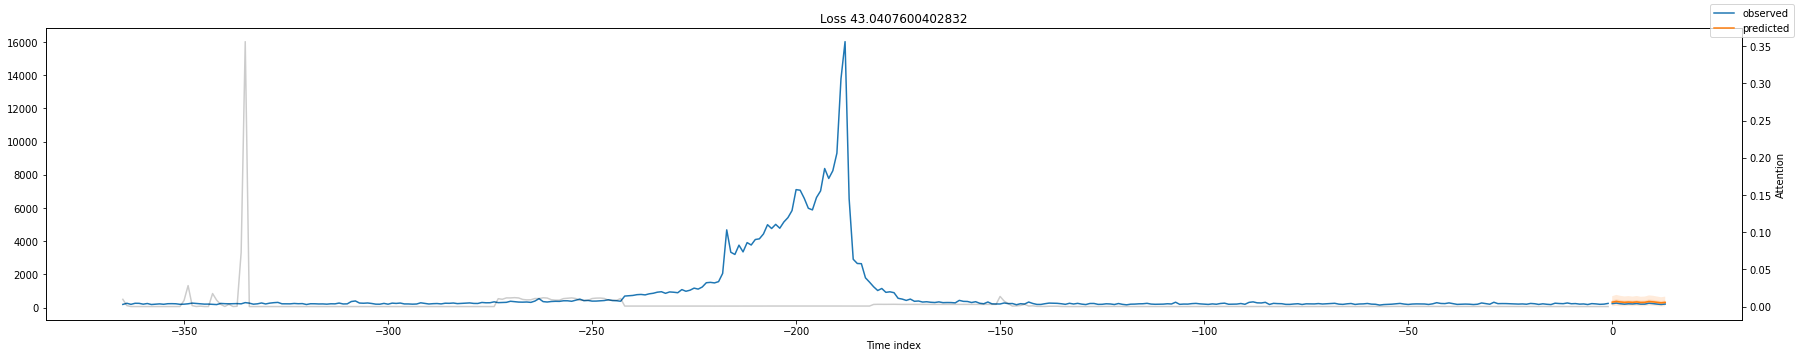

In [13]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x["article"] == "All_I_Want_for_Christmas_Is_You")),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0,add_loss_to_title=True)

Custom plotting

tensor([10687.,  9575.,  8910.,  8601.,  9029., 10067., 10546., 10148.,  8976.,
         9334.,  9915., 10354., 11349., 11952.])
[10687  9575  8910  8601  9029 10067 10546 10148  8976  9334  9915 10354
 11349 11952]


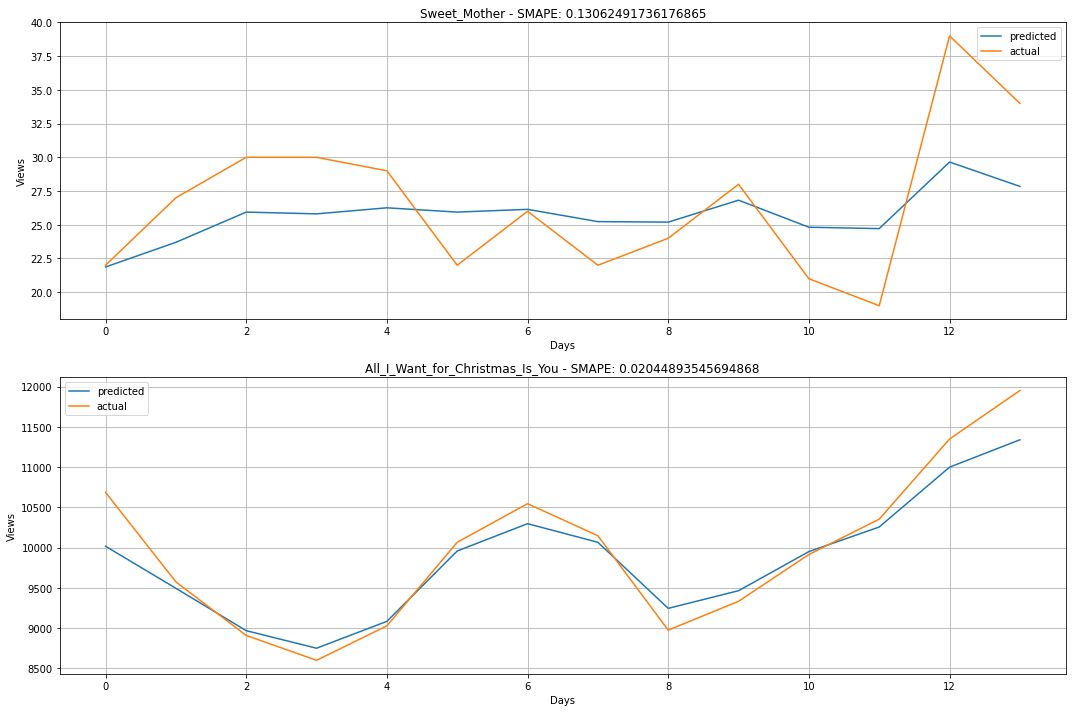

In [19]:
# calculate metric by which to display
import matplotlib.pyplot as plt

predictions = tft.predict(val_dataloader)
actuals = torch.cat([y for _, (y, _) in iter(val_dataloader)])

song1 = 39
loss1 = smape(predictions[song1].cpu().detach().numpy(),actuals[song1].cpu().detach().numpy())
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(15,10),tight_layout=True)
fig.tight_layout()
axs[0].plot(predictions[song1],label="predicted")
axs[0].plot(actuals[song1],label="actual")
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel("Days")
axs[0].set_ylabel("Views")
axs[0].title.set_text(data["article"].unique()[song1] +f" - SMAPE: {loss1}")


song2 = 3
loss2 = smape(predictions[song2].cpu().detach().numpy(),actuals[song2].cpu().detach().numpy())
axs[1].plot(predictions[song2],label="predicted")
axs[1].plot(actuals[song2],label="actual")
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlabel("Days")
axs[1].set_ylabel("Views")
axs[1].title.set_text(data["article"].unique()[song2] +f" - SMAPE: {loss2}")


plt.show()
#plt.savefig("test.png",dpi=500,height=1200,width=50)

<AxesSubplot:>

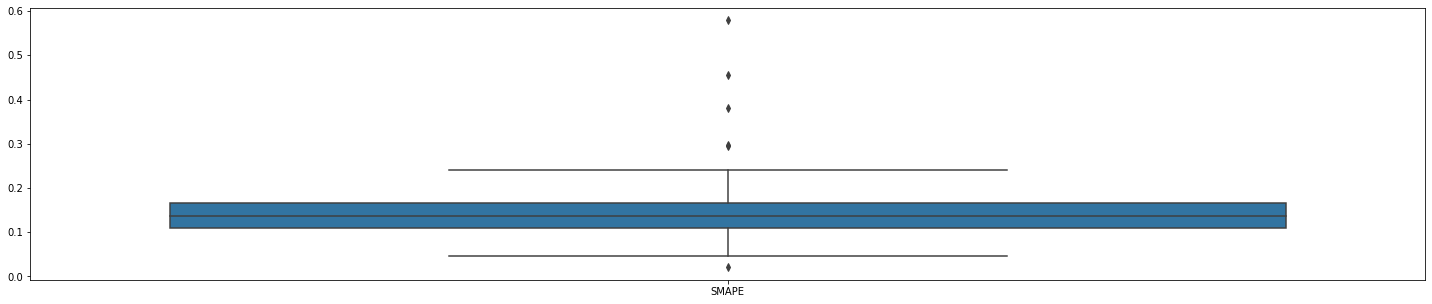

In [47]:
import seaborn as sns
losses = {"SMAPE":[]}
for i in range(51):
    losses["SMAPE"].append(smape(predictions[i].cpu().detach().numpy(),actuals[i].cpu().detach().numpy()))
sns.boxplot(data=pd.DataFrame(data=losses),orient="v")

In [119]:
import plotly.express as px

df = pd.DataFrame({"Time":[422,63],
                   "Model":["Transformer","Transformer"],
                   "Training Type":["Training","Optimizing"]
                   })
fig = px.bar(df,y="Time",x="Model",color="Training Type",text="Time",color_discrete_sequence=px.colors.qualitative.T10)
fig.update_yaxes(title="Time in Minutes")
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0,
    xanchor="right",
    x=1.25,
    bgcolor="LightSteelBlue",
),title={
    "text":"Training Time",
    "x":0.45
})
min = 99999
max = 0

counter = 0
temp = 0
for t,_,_ in df.values:
    temp += t
    counter += 1
    if counter == 2:
        if temp> max:
            max = temp
        elif temp < min:
            min = temp
        temp = 0
        counter = 0

fig.update_traces(width=0.4)
fig.add_annotation(x=0, y=500,
            text="Total: 485 Minutes (08h:05m)",
            showarrow=False,font_size=15,font_family="Arial Black")
fig.show()
#fig.write_image("training_time.png",format='png',engine='kaleido',scale=3)


##### Models Overview

|  Abbr. |Name   |Description   |SMAPE|MAPE|RMSE|Training Zeit
|---|---|---|---|---|---|---|
|a   |model_hidden6_oneMonth   | Has 6 hidden layers and trained using the past 30 days  |0.193|0.221|255.23|~06:18|
|b  |model_hidden16_oneMonth   | Has 16 hidden layers and trained using the past 30 days   |0.185|0.219|221.69|~09:33|
|c   |model_hidden6_oneYear   | Has 6 hidden layers and trained using the past 365 days   |0.139|0.149|148.75|~08:18|
|d   |model_hidden16_oneYear  | Has 16 hidden layers and trained using the past 365 days   |0.136|0.146|139.9|~14:33|
|e   |model_hidden16_oneYear_updatedIndex  | Has 16 hidden layers and trained using the past 365 days (differnet index than previous models)  |0.186|0.176|243.1|~7:02|
|A   |model_hidden6_oneMonth_optimized   | model (a) with optimized hyperparameters  |0.0055|0.0072|80.23|~(06:18 + 00:52)|
|B   | model_hidden16_oneMonth_optimized  | model (b) with optimized hyperparameters  |0.0052|0.0078|71.69|~(09:33 + 01:34)|
|C   |model_hidden6_oneYear_optimized   | model (c) with optimized hyperparameters  |0.0043|0.0088|33.75|~(08:18 + 00:58)|
|D   | model_hidden16_oneYear_optimized  | model (d) with optimized hyperparameters |0.0037|0.0061|27.9|~(14:33 + 01:46)|
|E   | model_hidden16_oneYear_optimized_updatedIndex   | model (e) with optimized hyperparameters |0.076|0.083|101.3|~(07:02 + 01:03)|



